In [13]:
import numpy as np
from matplotlib import pyplot as plt

folder_path = 'data/source/'               # Путь в папку где лежат исходные данные
output_path = 'data/'
detector_in_radius = 0.015          # Внутренний радиус детекторов
detector_out_radius = 0.025         # Внешний радиус детекторов
detector_distances = [1]  # Расстояния установки детекторов
time_accuracy = 0.05                # Точность с которой пишется время прилета в нс
# time_accuracy = 1e-9               # Точность с которой пишется время прилета в нс
n_angles = 8                       # На сколько сегментов детектор разбивается по углам
n_radii = 4                         # На сколько сегментов детектор разбивается по
augmentation = False                # Добаввлять аугментацию? Да - True; Нет - False
write_beam_angle = False             # Записывать вместо номера ячейки угол относительно пучка
maximum_hits = 60                   # Максимальное количество частиц, попавших в детекторы в одном событии. Для разбиения 8х4 следует ставить 80-100
n_lines = 3                         # Количество линий информации. Первая - время прилета, Вторая - номер ячейки детектора, Третья - номер детектора
name_of_file = 'PD117_test'         # Имя файла, в который будет записана информация. Записывается в папку data/ с расширением .dat
N_of_files = 10                      # Количество файлов исходных данных  (у меня максимум 111)
efficiency = 100                     # Эффективность регистрации детектора, в процентах (%)
# В эксперименте скорее всего 0.3
gauss_sigma = 0.15                  # Standard deviation для определения места столкновения (в метрах)
# size_of_random = 0.5                 # Размер разброса для определения места столкновения (равномерно распределено в пределах [-s_o_r, +s_o_r])


# dist = 7
# detector_in_radius = detector_in_radius * dist
# detector_out_radius = detector_out_radius * dist
# detector_distances = [dist]


In [2]:
class Collision_event:
    def __init__(self, b, coordinate, phi_b, particles) -> None:
        self.b = b
        self.coordinate = coordinate
        self.phi_b = phi_b
        self.particles_list = particles

class Particle_hit:
    def __init__(self, index, time, px, py, pnorm, det_num) -> None:
        self.index = index
        self.time = time
        self.px = px
        self.py = py
        self.pnorm = pnorm
        self.det_num = det_num
        

test = Collision_event(1, 2, 4, [1, 2, 3])
print(test)


In [3]:
# mass in GeV/c^2
proton_mass = 0.938272
masses_dict = {'211': 0.139570, '2212': 0.938272, '3112': 1.197449, '321': 0.493677, '3222': 1.18937,
              '3312': 1.32171, '3334': 1.67245, '-211': 0.139570, '-2212': 0.938272, '-3112': 1.197449, 
              '-321': 0.493677, '-3222': 1.18937, '-3312': 1.32171, '-3334': 1.67245}
# Определение массы частицы по ее индексу
def get_particle_mass(p_index: str) -> float:
    if len(p_index) != 10:
        return masses_dict[p_index]
    else:
        m = (int(p_index) % 10000) // 10
        return float(m * proton_mass)
        
# Вычисление скорости частицы по ее импульсу и индексу   
def calc_velocity(p: float, pz: float, ptype: str) -> float:
    return abs(pz) / np.sqrt(get_particle_mass(ptype) **2 + p**2 / 1**2)

# Вычисление времени пролета по скорости и расстоянию до детектора
def calc_time(v: float, distance: float) -> float:
    c = 2.99722458 * 10**8
    velocity = v * c
    time = distance / velocity
    return time

# Поворот на угол, задаваемый случайным числом randomizer
def random_rotation(angle, max_angle, randomizer):
    new_angle = angle + randomizer * max_angle
    if (new_angle == np.pi) or (new_angle == -np.pi):
        new_angle -= 0.00000001
    if new_angle > np.pi:
        new_angle -= 2*np.pi
    elif new_angle < -np.pi:
        new_angle += 2*np.pi
    return new_angle


def get_p_value(p_index: str) -> int:
    if (p_index == '211' or p_index == '-211'):          # pions
        return 1
    elif (p_index == '2212' or p_index == '-2212'):         # protons
        return 2
    else:
        return 3

# Вычислений времени пролета до детекторов на расстояниях det_num со скоростью света в наносекундах
speed_of_light = 299792456
light_times = [x * (10 **9) / speed_of_light for x in detector_distances ]
print(light_times)

# Нормировка времени пролета (t_light / t) на расстоянии current_distance
def normalize_time(t: float, dist: float):
    t_light = dist  * (10**9) / speed_of_light
    return  t_light / t
   

[33.35640974234522]


In [24]:
n_rings = len(detector_distances)
events = []
events_class = []

times_of_flight = {'pions': [], 'protons': []}
phi_bs = []
# Чтение 11 файлов с данными из папки 
final_file = N_of_files + 1
for i in range(1, final_file):        # iterate over all 11 given files of simulated events (from 1 to 11)
    filename = folder_path + "data_" + str(i) + ".dat"
    with open(filename,'r') as inpf: 
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        l = inpf.readline()
        
        for l in inpf.readlines():
            s=l.strip().split()
            if len(s) == 5:
                n,npart,b,bx,by = int(s[0]),int(s[1]),float(s[2]),float(s[3]),float(s[4])
                # 
                hits = []
                particle_hits = []
                for j in range(n_rings):
                    hits.append([[],[]])     # for every detector, negative and positive Pz side
                phi_b = np.arctan2(bx,by)

                coordinate = np.random.normal(loc=0, scale=gauss_sigma)                                                     # Нормальное распределение
                # coordinate = (size_of_random * 2 * np.random.rand()) - size_of_random                                     # Равномерное распределение
                # coordinate = 0                                                                                            # 0
                if abs(coordinate) > detector_distances[0]:
                    coordinate = 0

                # events.append([b, coordinate, phi_b, hits])
                events_class.append(Collision_event(b,coordinate, phi_b, particle_hits))                                       #
                phi_bs.append(phi_b)
            elif len(s) == 11:
                p_charge = int(s[0].strip())
                ptype = s[4].strip()

                px = float(s[5])
                py = float(s[6])
                pz = float(s[7])
                p_along = abs(pz)
                p_across = np.sqrt(px**2+py**2)
                p_full = np.sqrt(p_across **2 + p_along **2)
                
                # Обработка всех частиц с ненулевым зарядом
                if p_charge != 0:
                    for ind in range(n_rings):    # for every detector check if particle hit it
                        if pz > 0:
                            direction = 1
                            current_distance = detector_distances[ind] - coordinate
                        elif pz < 0:
                            direction = 0
                            current_distance = detector_distances[ind] + coordinate
                        under_upper_bound = (p_across / p_along) < (detector_out_radius / current_distance)
                        above_lower_bound = (p_across / p_along) > (detector_in_radius / current_distance)
                        hit_detector =  under_upper_bound and above_lower_bound
                        if hit_detector:
                            det_number = 1 + ind * 2 + direction                                                # Проверить правильность + и - направлений, при надобности изменить
                            pnorm=np.sqrt(px**2+py**2+pz**2)
                            pxn=px/pnorm
                            pyn=py/pnorm
                            p_velocity = calc_velocity(p_full, pz, ptype)
                            p_time = calc_time(p_velocity, current_distance)
                            # hits[ind][direction].append([ptype, p_time, [pxn,pyn,pnorm]])

                            particle_hits.append(Particle_hit(ptype, p_time, pxn, pyn, pnorm, det_number))          #

                            if (ptype == '211' or ptype == '-211'):                                  # пионы
                                times_of_flight['pions'].append(p_time)
                            elif (ptype == '2212' or ptype == '-2212'):                              # протоны
                                times_of_flight['protons'].append(p_time)
            
                        
    print("File #{} has been read".format(i))
  
# events = sorted(events, key=lambda x: (x[0]))
events_class = sorted(events_class, key=lambda x: (x.b))

# plt.hist(phi_bs, bins=16)
# plt.show()

# events[j]: j - number of event, events[j][3] - info, events[j][3][i] i - number of detector,
# events[j][3][i][0/1] - negative or positive Pz, events[j][3][i][0/1][k] - k - number of hit 
# events[j][3][i][0/1][k][0] - particle type, events[j][3][i][0/1][k][1] - time from event to hitting of detector
# events[j][3][i][0/1][k][2] - pxn, pyn, pnorm

File #1 has been read
File #2 has been read
File #3 has been read
File #4 has been read
File #5 has been read
File #6 has been read
File #7 has been read
File #8 has been read
File #9 has been read
File #10 has been read


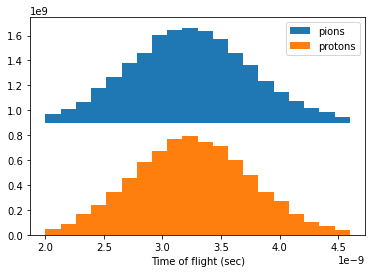

In [31]:
plt.hist(times_of_flight['pions'], range=(2 * 1e-9, 4.6 * 1e-9), bins=20, density=True, bottom=9*1e8, label='pions')
plt.hist(times_of_flight['protons'],range=(2 * 1e-9, 4.6 * 1e-9), bins=20, density=True, label='protons')
plt.legend()
plt.xlabel("Time of flight (sec)")
plt.savefig("Presentations/Diplom/PiPr_hist_15coord_TTTTT", dpi=300)
plt.show()

In [10]:
print("Обработано {} событий".format(len(events_class)))

def remove_column(arr, index):
    lhs = arr[:,:,:index]
    rhs = arr[:,:,index+1:]
    res = np.concatenate((lhs, rhs), axis=2)
    return res

def remove_repeated_det_hits(arr):
    existed = []
    res = np.zeros((n_lines, 1, n_detectors))
    written_particles = 0
    for i in range(arr.shape[2]):
        if written_particles == 6:
            return res
        if not (arr[2][0][i] in existed):
            res[0][0][written_particles] = arr[0][0][i]
            res[1][0][written_particles] = arr[1][0][i]
            res[2][0][written_particles] = arr[2][0][i]
            existed.append(arr[2][0][i])
            written_particles += 1
    return res

def make_positioned(arr):
    current_res = remove_repeated_det_hits(arr)
    res = np.zeros((n_lines, 1, n_detectors))
    for i in range(n_detectors):
        index = int(current_res[2][0][i])
        if index != 0:
            index -= 1
            res[0][0][index] = current_res[0][0][i]
            res[1][0][index] = current_res[1][0][i]
            res[2][0][index] = current_res[2][0][i]
    return res

def detector_wise_sort(arr):
    res = np.zeros((2, 1, maximum_hits), dtype=float)
    det_hits = np.zeros(6, dtype=int)

    for i in range(arr.shape[2]):   # По всем записям в массиве
        det_num = int(arr[2][0][i])      # Номер детектора (1-6)
        if det_num != 0:            # Если номер 0, то хита нет и можно закрывать цикл
            det_num -= 1            # Номер детектора (0-5)
            if det_hits[det_num] < 10:      # Если в этот детектор записано меньше 10 частиц
                index = det_num * 10 + det_hits[det_num]    # индекс - десятка от номера детектора + номер попадания
                res[0][0][index] = arr[0][0][i]             # Время
                res[1][0][index] = arr[1][0][i]             # Ячейка
                det_hits[det_num] += 1                      # В этот детектор +1 частица
        else:
            break
    return res

def substract_fist_particle_time(arr):
    res = np.array(arr, dtype=float)
    non_zero = np.count_nonzero(arr[0][0])
    first_particle_time = min(arr[0][0][:non_zero])

    for i in range(non_zero):
        res[0][0][i] -= first_particle_time
    return [res, first_particle_time]

N_protons = []
N_pions = []
N_protons_pions = []
b_s = []

n_detectors = 2*n_rings
detector_width = detector_out_radius - detector_in_radius
number_of_hits = np.zeros(3)
# Среднее время прилета пионов для детекторов на [1, 1.7, 2,5] метрах, используется для нелинейного преобразования времени
avg_pion_times = [3.345, 5.675, 8.355]
max_hits = np.zeros(6, dtype=int)


one_ring_width = detector_width / n_radii
rings_width = []
# Разбиение детектора на n_radii одинаковых колец
for i in range(n_radii):
    rings_width.append(one_ring_width)

# Вычисление координат границ детекторов используя ширины колец
detector_borders = []
for i in range(len(rings_width)):
    rad = detector_in_radius
    for j in range(i,0,-1):
        rad += rings_width[j-1]
    detector_borders.append(rad)
detector_borders.append(detector_out_radius)
print("Границы радиального разбиения на {}".format(detector_borders))

mean_radii = []
for i in range(n_radii):
    mean_radii.append( (detector_borders[i] + detector_borders[i + 1])/2 )
print("Средние значения радиусов: {}".format(mean_radii))


event_data=np.zeros((n_detectors, n_angles, n_radii), dtype=np.float32)
if augmentation:
    augm_event_data=np.zeros((n_detectors, n_angles, n_radii), dtype=np.float32)
n = 0 
file_name = output_path + name_of_file + '.dat'
with open(file_name, 'w') as outf:
    outf.write('Maximum hits: ' + str(maximum_hits) + ' Lines: ' + str(n_lines) + '\n')
    for e in events_class:    # iterate over events
        event_data_2 = []
        if augmentation:
            augm_event_data_2 = []
        for i in range(n_lines): # листы: время, координата попадания, номер кольца
            event_data_2.append([])
            if augmentation:
                augm_event_data_2.append([])
        n += 1
        all_hits = sorted(e.particles_list, key=lambda x: (x.time))    # all hits for one event

        phi_b = e.phi_b
        coordinate = e.coordinate
        b = e.b
        b_s.append(b)
        if augmentation:
            randomizer = 2*np.random.random_sample() - 1

        det_num = 0

        particle_in_zero_direction = False
        particle_in_first_direction = False
        n_protons = 0
        n_pions = 0
        for hit in all_hits:    # Iterate over all particle hits
            if np.random.randint(0,100) < efficiency:
                p_type = hit.index
                det_value = hit.det_num
                det_num = (det_value - 1) // 2
                dir_num = (det_value - 1) % 2

                if (p_type == '211' or p_type == '-211'):                                  # пионы
                    n_pions += 1
                if (p_type == '2212' or p_type == '-2212'):                              # протоны
                    n_protons += 1

                # Применяем нелинейное преобразование времени(записанного с заданной точностью), используя информацию о времени пролета пионов
                particle_time = time_accuracy * ((hit.time * 10**9)// time_accuracy)  
                # particle_value = 1 / (particle_time - avg_pion_times[det_num]) 
                particle_value = particle_time
                # particle_value = normalize_time(particle_time, current_distance)

                       
                angle = np.arctan2(hit.px, hit.py)
                radius = np.sqrt(hit.px ** 2 + hit.py ** 2)
                angle_bin = np.floor(n_angles*(angle/2/np.pi+0.5))
                angle_bin = angle_bin.astype(int)

                # Вычисление радиальной координаты прилета частицы
                current_distance = detector_distances[det_num] + coordinate * (1 if dir_num == 0 else -1)
                rad = radius * current_distance
                '''
                if (rad < detector_borders[0]) or (rad > detector_borders[n_radii]):
                    print('RADIUS {} OUT OF BOUNDS at dist {}'.format(rad, current_distance))
                '''
                for i in range(len(detector_borders) - 1):
                    if detector_borders[i] < rad <= detector_borders[i+1]:
                        r_bin = i
                        break
                
                # beam_angle = np.arctan2(mean_radii[r_bin], detector_distances[det_num])
                beam_angle = np.arctan2(mean_radii[r_bin], current_distance)

                if augmentation:
                    # augmented data
                    augm_angle = random_rotation(angle, np.pi, randomizer)
                    augm_angle_bin = np.floor(n_angles*(augm_angle/2/np.pi+0.5))
                    augm_angle_bin = augm_angle_bin.astype(int)



                if event_data[det_num * 2 + dir_num, angle_bin, r_bin] == 0:
                    event_data[det_num * 2 + dir_num, angle_bin, r_bin] = particle_value
                    event_data_2[0].append(particle_value)

                    # event_data_2[1].append(r_bin * n_angles + angle_bin + 1)
                    # event_data_2[1].append(angle_bin * n_radii + r_bin + 1)

                    if write_beam_angle:
                        event_data_2[1].append(beam_angle)
                    else:
                        event_data_2[1].append(r_bin * n_angles + angle_bin + 1)
                    

                    event_data_2[2].append(det_value)
                    # event_data_2[3].append(get_p_value(p_type))
                    # event_data_2[4].append(get_particle_mass(p_type))
                    if augmentation:
                        augm_event_data_2[0].append(particle_value)
                        augm_event_data_2[1].append(r_bin * n_angles + augm_angle_bin + 1)
                        augm_event_data_2[2].append(det_num * 2 + dir_num + 1)
                                    
                            
                    number_of_hits[det_num] += 1
                ''' # Использовалось для оценки количества повторных попаданий
                else:
                    repeated_hits += 1
                    repeated_radii[det_num].append(radius*detector_distances[det_num])
                    repeated_distribution[det_num][r_bin] += 1
                '''
                if dir_num == 0:
                    particle_in_zero_direction = True
                else:
                    particle_in_first_direction = True


        N_protons.append(n_protons)
        N_pions.append(n_pions)
        N_protons_pions.append(n_protons + n_pions)
        # Ниже идет запись данных в файл
        # Проверка условия для отсеивания пустых событий
        if event_data_2[0]:                                    # Отсеивание событий где ни одна частица не регистрируется
        # if set(event_data_2[2]) == {1, 2, 3, 4, 5, 6}:         # Выбор только событий где все шесть колец задействованы
        # if particle_in_zero_direction and particle_in_first_direction:      # Выбор только событий где есть частицы с обоих сторон
        # outf.write(str(b) + ' ' + str(coordinate) + ' ' + str(phi_b) + ' ' + str(n_pions) + ' ' + str(n_protons) + '\n')
        # if True:                                                 # Нет отсеивания

            evdata2 = np.array(event_data_2)

            # event_data_new = np.array(np.c_[evdata2, np.zeros((n_lines, maximum_hits - evdata2.shape[1]))])
            event_data_new = np.array(np.c_[evdata2, np.zeros((n_lines, 60 - evdata2.shape[1]))])                                           #
            output = np.reshape(event_data_new, (n_lines, 1, -1)).astype(np.float32)
            # output = remove_repeated_det_hits(output)                                                                             # По одной частице в детектор
            # output = make_positioned(output)                                                                                        # По одной частице в детектор, частицы на своих местах
            # output = detector_wise_sort(output)                                                                                         # Подетекторная сортировка
            [output, time_of_first] = substract_fist_particle_time(output)                                                                               # Вычесть из всех времен время прилета первой частицы
            
            outf.write(str(b) + ' ' + str(coordinate) + ' ' + str(time_of_first) + ' ')
            # outf.write(str(b) + ' ' + str(coordinate) + ' ' + str(phi_b) + ' ')
            for j in range(output.shape[0]):    # write into file
                for i in range(output.shape[2]):
                    outf.write(str(output[j][0][i]))
                    outf.write(' ')
                outf.write('   ')
            outf.write('\n')

            if augmentation:
                augm_evdata2 = np.array(augm_event_data_2)
                # augm_event_data_new = np.array(np.c_[augm_evdata2, np.zeros((n_lines, maximum_hits - augm_evdata2.shape[1]))])
                augm_event_data_new = np.array(np.c_[augm_evdata2, np.zeros((n_lines, 60 - augm_evdata2.shape[1]))])                        #
                
                outf.write(str(b) + ' ' + str(coordinate) + ' ' + str(phi_b) + ' ')
                augm_output = np.reshape(augm_event_data_new, (n_lines, 1, -1)).astype(np.float32)      
                for j in range(augm_output.shape[0]):    # write into file
                    for i in range(augm_output.shape[2]):
                        outf.write(str(augm_output[j][0][i]))
                        outf.write(' ')
                    outf.write('   ')
                outf.write('\n')
            
            for j in range(output.shape[0]):    
                # print(j, np.count_nonzero(output[j]))
                max_hits[j] = max(np.count_nonzero(output[j]), max_hits[j])
            if n% int(len(events_class) / 10) == 0:
                print("Записано {:3.0f}% событий".format(n * 100 / len(events_class)))
                # Две строки в которых отслеживался прогресс записи и максимальное число попаданий
                '''print('{} from {}'.format(np.count_nonzero(output[0]), (len(e[2][0][0]) + len(e[2][0][1]) + len(e[2][1][0]) + len(e[2][1][1]) + len(e[2][2][0]) + len(e[2][2][1]) )))
                print("Максимальное количество попаданий по детекторам {}".format(max_hits))
                '''
        event_data*=0.0
        event_data = abs(event_data)
print("Максимальное количество попаданий по детекторам {}".format(max_hits))

Обработано 20000 событий
Границы радиального разбиения на [0.015, 0.0175, 0.020000000000000004, 0.022500000000000006, 0.025]
Средние значения радиусов: [0.01625, 0.018750000000000003, 0.021250000000000005, 0.023750000000000004]
Записано  10% событий
Записано  20% событий
Записано  30% событий
Записано  40% событий
Записано  50% событий
Записано  60% событий
Записано  70% событий
Записано  80% событий
Записано  90% событий
Максимальное количество попаданий по детекторам [49 53 53  0  0  0]


1.03795


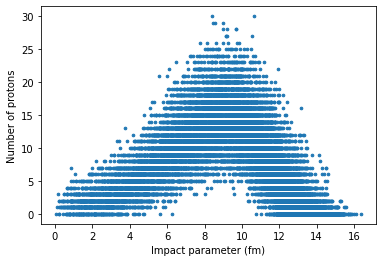

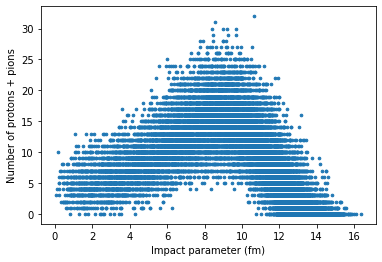

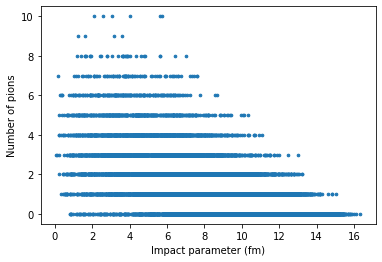

In [11]:
marker_size = 7

print(np.average(np.array(N_protons_pions) - np.array(N_protons)))
plt.scatter(b_s, N_protons, s=marker_size)
plt.xlabel('Impact parameter (fm)')
plt.ylabel('Number of protons')

plt.savefig('Presentations/21_12_29/proton_b_corr_small.png', dpi=300)
plt.show()

plt.scatter(b_s, N_protons_pions, s=marker_size)
plt.xlabel('Impact parameter (fm)')
plt.ylabel('Number of protons + pions')

plt.savefig('Presentations/21_12_29/proton_and_pion_b_corr_small.png', dpi=300)
plt.show()

plt.scatter(b_s, N_pions, s=marker_size)
plt.xlabel('Impact parameter (fm)')
plt.ylabel('Number of pions')

plt.savefig('Presentations/21_12_29/pion_b_corr.png', dpi=300)
plt.show()

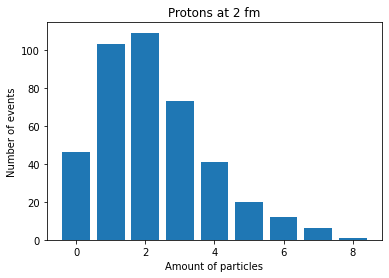

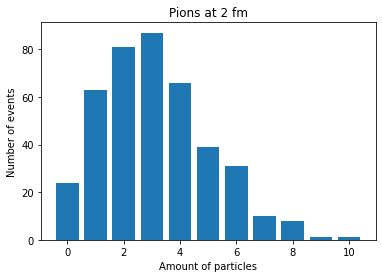

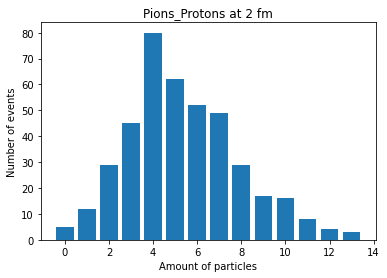

In [37]:
left_border = 1.5
right_border = left_border + 1

new_N_protons = []
new_N_pions = []
new_N_pipr = []

for i in range(len(b_s)):
    if  left_border < b_s[i] < right_border:
        new_N_protons.append(N_protons[i])
        new_N_pions.append(N_pions[i])
        new_N_pipr.append(N_protons_pions[i])


def plot_bar_particles(arr, impact_parameter, xlabel, ylabel, saveimg=False, nameimg=None):
    left_border = impact_parameter - 0.5
    right_border = impact_parameter + 0.5
    new_arr = []
    for i in range(len(b_s)):
        if left_border < b_s[i] < right_border:
            new_arr.append(arr[i])
    labels, counts = np.unique(new_arr, return_counts=True)
    plt.bar(labels, counts)
    plt.title((nameimg + ' at ' + str(impact_parameter) + ' fm'))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if saveimg:
        plt.savefig(('Presentations/21_12_29/hists_of_' + nameimg + '_at_' + str(impact_parameter) + '_fm'), dpi=300)
    plt.show()



b = 2
plot_bar_particles(N_protons, b, xlabel="Amount of particles", ylabel="Number of events", saveimg=True, nameimg="Protons")
plot_bar_particles(N_pions, b, xlabel="Amount of particles", ylabel="Number of events", saveimg=True, nameimg="Pions")
plot_bar_particles(N_protons_pions, b, xlabel="Amount of particles", ylabel="Number of events", saveimg=True, nameimg="Pions_Protons")